In this notebook we compare performance of the NTK, FC-CNTK, and GAP-CNTK on the dataset considered in the lecture. We begin by building this dataset. 

In [1]:
import numpy as np

SEED = 32
np.random.seed(SEED)

d = 100

def sample_conv_data(num_samples, train=True):
    X = np.zeros((num_samples, d))
    window_size = 3
    if train:
        pos = np.random.choice(list(np.arange(d//4)), size=num_samples//2, replace=False)
        for idx, p in enumerate(pos):
            X[idx, p-window_size//2:p+window_size//2 +1] = 1.
        pos = np.random.choice(list(np.arange(d//4)), size=num_samples//2, replace=False)
        for idx, p in enumerate(pos):
            X[num_samples//2+idx, p-window_size//2:p+window_size//2 +1] = -1.
        y = np.ones((num_samples, 1))
        y[num_samples//2:] *= -1
    else:
        pos = np.random.choice(list(np.arange(d//4, d)), size=num_samples//2, replace=False) 
        for idx, p in enumerate(pos):
            X[idx, p-window_size//2:p+window_size//2 +1] = 1.
        pos = np.random.choice(list(np.arange(d//4, d)), size=num_samples//2, replace=False) 
        for idx, p in enumerate(pos):
            X[num_samples//2 + idx, p-window_size//2:p+window_size//2 +1] = -1.
        y = np.ones((num_samples, 1))
        y[num_samples//2:] *= -1
    return X, y

X_train, y_train = sample_conv_data(num_samples=10, train=True)
X_test, y_test = sample_conv_data(num_samples=50, train=False)

The dataset consists of 100 dimensional vectors where there is a small strip colored red or blue indicating the class label.  The training data has these colors appearing on the left side of the vector and the test data has the strips appearing on the right side of the vector.  

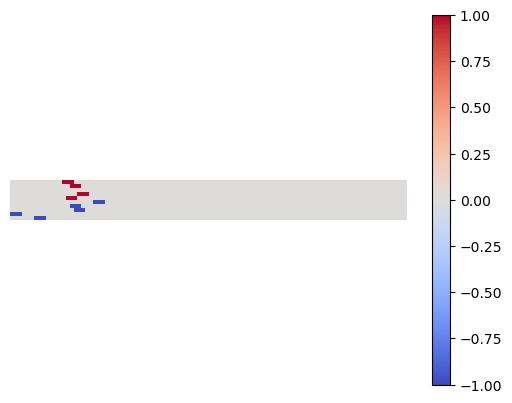

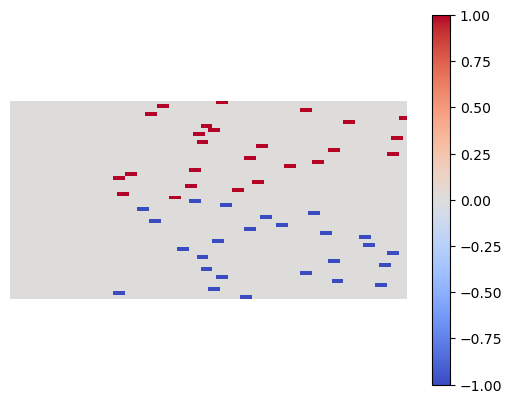

In [2]:
import matplotlib.pyplot as plt

plt.imshow(X_train, cmap='coolwarm')
plt.axis('off')
plt.colorbar()
plt.show()

plt.imshow(X_test, cmap='coolwarm')
plt.axis('off')
plt.colorbar()
plt.show()

While fully connected nets and the NTK cannot generalize on this task, we show that GAP-CNTKs can generalize.  We implement the FC-CNTK and GAP-CNTK below. 

In [4]:
from patchify import patchify 

def relu_ntk(pair1, pair2):

    out = pair1 @ pair2.transpose(1, 0) + 1
    N1 = np.sum(np.power(pair1, 2), axis=-1).reshape(-1, 1) + 1
    N2 = np.sum(np.power(pair2, 2), axis=-1).reshape(-1, 1) + 1

    XX = np.sqrt(N1 @ N2.transpose(1, 0))
    out = out / XX

    out = np.clip(out, -1, 1)
    out = np.nan_to_num(out)
    first = 1/np.pi * (out * (np.pi - np.arccos(out)) \
                       + np.sqrt(1. - np.power(out, 2))) * XX
    sec = 1/np.pi * out * (np.pi - np.arccos(out)) * XX
    out = first + sec
    return out, first, sec

def get_patches(X, window=3):
    X_patches = []
    for i in range(len(X)):
        patches = patchify(X[i], (window), 1)
        X_patches.append(patches)
    X_patches = np.array(X_patches)
    return X_patches

def zero_pad(X, window=3):
    n, d = X.shape
    X_padded = np.zeros((n, d+(window-1)//2 + 1))
    X_padded[:, (window-1)//2:d+(window-1)//2] = X    
    return X_padded

def cntk(X, Z, window=3, gap=True):
    n, d = X.shape
    X = zero_pad(X)
    Z = zero_pad(Z)
    
    X_patches = get_patches(X, window=window)
    Z_patches = get_patches(Z, window=window)
    nx, bx, cx = X_patches.shape
    nz, bz, cz = Z_patches.shape
    
    X_patches = X_patches.reshape(nx * bx, cx)
    Z_patches = Z_patches.reshape(nz * bz, cz)
    _, _, K = relu_ntk(X_patches, Z_patches)
    K = K.reshape(nx, bx, nz, bz)
    K = np.rollaxis(K, 1, 3)
    if gap:
        K = np.mean(K, axis=(2, 3))
    else:
        K = np.mean(K*np.eye(bx), axis=(2,3))
    return K

In [5]:
from numpy.linalg import solve

class ReLU_NTK():

    def __init__(self, ntk=True):
        self.sol = None
        self.X_train = None
        self.ntk = ntk
        
    def fit(self, X, y, reg=0):
        self.X_train = X
        N, S, _ = relu_ntk(self.X_train, self.X_train)
        if self.ntk:
            K = N
        else: 
            K = S
        sol = solve(K + reg * np.eye(len(K)), y).T
        self.sol = sol
        return self

    def predict(self, X):
        N, S, _ = relu_ntk(self.X_train, X)
        if self.ntk: 
            K = N
        else:
            K = S
        return (self.sol @ K).T

In [6]:
class ReLU_CNTK():

    def __init__(self, gap=True):
        self.sol = None
        self.X_train = None
        self.gap = gap

    def fit(self, X, y, reg=0):
        self.X_train = X
        K = cntk(self.X_train, self.X_train, gap=self.gap)
        sol = solve(K + reg * np.eye(len(K)), y).T
        self.sol = sol
        return self

    def predict(self, X):
        K = cntk(self.X_train, X, gap=self.gap)
        return (self.sol @ K).T

In [7]:
def get_acc(y_pred, y_true):
    pred_sign = np.where(y_pred > 0, 1, -1)
    true_sign = np.where(y_true > 0, 1, -1)
    return np.mean(pred_sign == true_sign) * 100

from sklearn.metrics import r2_score
model = ReLU_NTK()
model.fit(X_train, y_train, reg=1e-4)

fc_train_preds = model.predict(X_train)
fc_test_preds = model.predict(X_test)

fc_train_acc = get_acc(fc_train_preds, y_train)
fc_test_acc = get_acc(fc_test_preds, y_test)
print("FC NTK Train Acc: ", fc_train_acc, "FC NTK Test Acc: ", fc_test_acc)

FC NTK Train Acc:  100.0 FC NTK Test Acc:  50.0


In [10]:
model = ReLU_CNTK(gap=False)
model.fit(X_train, y_train, reg=1e-4)

conv_train_preds = model.predict(X_train)
conv_test_preds = model.predict(X_test)

conv_train_acc = get_acc(conv_train_preds, y_train)
conv_test_acc = get_acc(conv_test_preds, y_test)
print("CNTK GAP Train Acc: ", conv_train_acc, "CNTK GAP Test Acc: ", conv_test_acc)

CNTK GAP Train Acc:  100.0 CNTK GAP Test Acc:  50.0
